In [1]:
import broadbean as bb
from broadbean.plotting import plotter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8, 3)
mpl.rcParams['figure.subplot.bottom'] = 0.15 



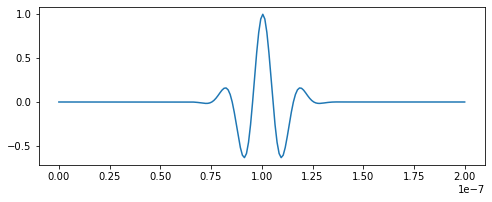

In [2]:
#%%
#practicing on a gaussian pulse, this is how you can use broadbean's primitives
g = bb.broadbean.PulseAtoms.gaussian(1, 10e-9, 0, 0, 1e9, 200)
s = bb.broadbean.PulseAtoms.sine(50e6, 1, 0, np.pi/2, 1e9, 100*2)
t = np.linspace(0, 200/1e9, 200)
plt.plot(t, g*s) #a guassian pulse at 50MHz!
#make the custom function #first t
def gaussian_pulse(freq, phase, ampl, sigma, mu, offset, SR, npts):
    g = bb.broadbean.PulseAtoms.gaussian(1, sigma, mu, offset, SR, npts)
    s = bb.broadbean.PulseAtoms.sine(freq, ampl, offset, phase, SR, npts)\
    return g*s


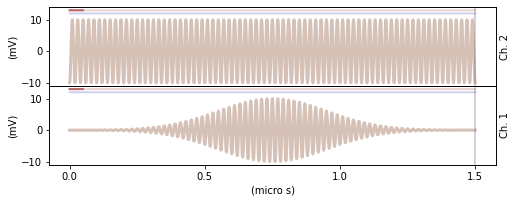

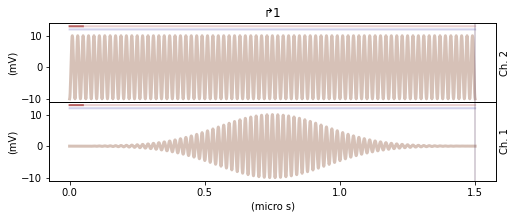

In [3]:
#all in one box,
# sine = bb.PulseAtoms.sine  # args: freq, ampl, off, phase
# bp1 = bb.BluePrint()
# bp1.setSR(1e9)
# bp1.insertSegment(1, 'waituntil', (300e-9,))

# # bp1.insertSegment(1, sine, (20e6, 5e-3, 0, 0), name='mysine', dur=201e-9)
# bp1.insertSegment(3, sine, (50e6, 50e-3, 0, 0), name='mysine', dur=201e-9)
# bp1.insertSegment(4, 'waituntil', (800e-9,))
# bp1.showPrint()
# plotter(bp1)
#make a basic sinusoidal element
sine = bb.PulseAtoms.sine  # args: freq, ampl, off, phase
bpsine = bb.BluePrint()
bpsine.setSR(1e9)
bpsine.insertSegment(1, sine, (50e6, 10e-3, 0, 3*np.pi/2), name='sine', dur=1501e-9)
bpsine.marker1 = [(0,50e-9)]

#make a gaussian pulse blueprint
gaussbp = bb.BluePrint()
gaussbp.setSR(1e9)
gaussbp.insertSegment(1, gaussian_pulse, (50e6,3*np.pi/2,10e-3,200e-9,0,0), name = 'gaussian', dur = 1501e-9)
gaussbp.marker1 = [(0,50e-9)]

sineEl = bb.Element()
sineEl.addBluePrint(2,bpsine)
sineEl.addBluePrint(1,gaussbp)
plotter(sineEl)




###############################################
#put elements into sequence
sineSeq = bb.Sequence()
sineSeq.addElement(1, sineEl)
sineSeq.setSR(1e9)

#now we have to prep it for the AWG
sineSeq.setChannelAmplitude(1, 50e-3)  # Call signature: channel, amplitude (peak-to-peak)
sineSeq.setChannelOffset(1, 0)
sineSeq.setChannelAmplitude(2, 50e-3) 
sineSeq.setChannelOffset(2, 0)

#set the sequencing
# Here we repeat each element twice and then proceed to the next, wrapping over at the end
sineSeq.setSequencingTriggerWait(1, 0)
sineSeq.setSequencingNumberOfRepetitions(1, 1)
sineSeq.setSequencingEventJumpTarget(1, 0)
sineSeq.setSequencingGoto(1, 1)

sineSeq.checkConsistency()
plotter(sineSeq)

In [159]:
#upload to AWG
package = sineSeq.outputForAWGFile()
chan1_awg_input = package[0]
package.channels
awg.make_send_and_load_awg_file(*package[:])